<a href="https://colab.research.google.com/github/Pooret/drug-discovery-ml/blob/main/ChemBert_Binding_Affinity_Prediction_for_Small_Molecules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Dataset](https://www.kaggle.com/competitions/leash-BELKA/data)

In [1]:
!pip install pandas pyarrow
!pip install duckdb
!pip install rdkit
!pip install py3Dmol
!pip install mordred
!pip install deepchem

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 56.7 MB/s eta 0:00:00
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176720 sha256=d164f1f475bdb301910795e546a5c734f179d47e478010b15cf59379b255ae62
  Stored in directory: /root/.cache/pip/wheels/a7/4f/b8/d4c6591f6ac944aaced7865b349477695f662388ad958743c7
Successfully built mordred
  Attempting uninstall: networkx
    Found existing installation: networkx 3.3
    Uninstalling networkx-3.3:
      Successfully uninstalled networkx-3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.0+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_mach

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
import os

# Create directory path for data
directory_path = "/content/data"

# Check if the directory already exists
if not os.path.exists(directory_path):
    os.mkdir(directory_path)
    print(f"Directory created at {directory_path}")
else:
    print(f"Directory already exists at {directory_path}")

Directory created at /content/data


In [4]:
%%time
!unzip /content/drive/MyDrive/Datasets/leash_BELKA/data.zip -d /content/data

Archive:  /content/drive/MyDrive/Datasets/leash_BELKA/data.zip
  inflating: /content/data/sample_submission.csv  
  inflating: /content/data/test.csv  
  inflating: /content/data/test.parquet  
  inflating: /content/data/train.csv  
  inflating: /content/data/train.parquet  
CPU times: user 1.82 s, sys: 259 ms, total: 2.08 s
Wall time: 5min 46s


In [30]:
%%time
#By Andrew D. Blevins https://www.kaggle.com/code/andrewdblevins/leash-tutorial-ecfps-and-random-forest

import duckdb
import pandas as pd

train_path = '/content/data/train.parquet'
test_path = '/content/data/test.parquet'

con = duckdb.connect()

max_limit = 1589906
limit_num = 30000

# 1589906 is the total number of binding samples
df = con.query(f"""(SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 0
                        ORDER BY random()
                        LIMIT {limit_num})
                        UNION ALL
                        (SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 1
                        ORDER BY random()
                        LIMIT {limit_num})""").df()

con.close()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CPU times: user 2min 18s, sys: 9.21 s, total: 2min 28s
Wall time: 36.5 s


In [31]:
df.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,157421086,O=C(Nc1cc(Br)c(Cl)cc1C(=O)O)OCC1c2ccccc2-c2ccc...,Cl.NC1CCC(=O)CC1,Cc1cccc(N)c1Cl,Cc1cccc(Nc2nc(Nc3cc(Br)c(Cl)cc3C(=O)N[Dy])nc(N...,HSA,0
1,42705092,CSc1ncc(NC(=O)OCC2c3ccccc3-c3ccccc32)c(C(=O)O)n1,COC1(OC)CC(CN)C1,CC(=O)c1ccc(N)c(F)c1,COC1(OC)CC(CNc2nc(Nc3ccc(C(C)=O)cc3F)nc(Nc3cnc...,sEH,0
2,68338321,N#Cc1ccc(NC(=O)OCC2c3ccccc3-c3ccccc32)c(C(=O)O)c1,NC[C@@H]1CCC(=O)N1,Cc1cc2cc(CN)ccc2[nH]1,Cc1cc2cc(CNc3nc(NC[C@@H]4CCC(=O)N4)nc(Nc4ccc(C...,HSA,0
3,204282053,O=C(Nc1ccc([N+](=O)[O-])c(C(=O)O)c1)OCC1c2cccc...,Cl.NCC(F)(F)C1CC1,Nc1cc(F)c(F)cc1Br,O=C(N[Dy])c1cc(Nc2nc(NCC(F)(F)C3CC3)nc(Nc3cc(F...,sEH,0
4,111143616,O=C(N[C@H](C(=O)O)C1CC1)OCC1c2ccccc2-c2ccccc21,CC(=O)SCCN.Cl,Nc1nc2ccccc2[nH]1,CC(=O)SCCNc1nc(Nc2nc3ccccc3[nH]2)nc(N[C@H](C(=...,BRD4,0


In [32]:
df.shape

(60000, 7)

<Axes: xlabel='protein_name'>

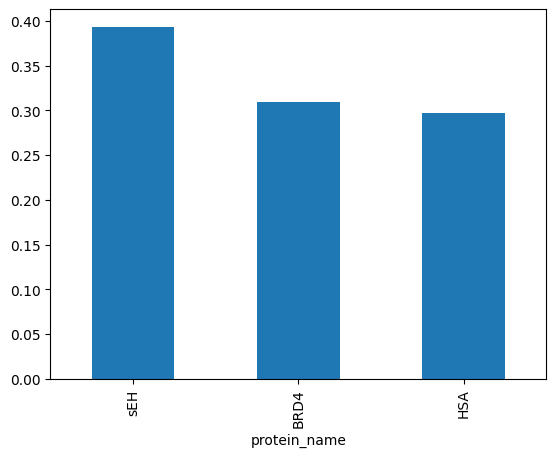

In [33]:
df['protein_name'].value_counts(normalize=True).plot(kind='bar')

### Targets

**EPHX2 (sEH)**

The first target, epoxide hydrolase 2, is encoded by the EPHX2 genetic locus, and its protein product is commonly named “soluble epoxide hydrolase”, or abbreviated to sEH. Hydrolases are enzymes that catalyze certain chemical reactions, and EPHX2/sEH also hydrolyzes certain phosphate groups. EPHX2/sEH is a potential drug target for high blood pressure and diabetes progression, and small molecules inhibiting EPHX2/sEH from earlier DEL efforts made it to clinical trials.

EPHX2/sEH was also screened with DELs, and hits predicted with ML approaches, in a recent study but the screening data were not published. We included EPHX2/sEH to allow contestants an external gut check for model performance by comparing to these previously-published results.

We screened EPHX2/sEH purchased from Cayman Chemical, a life sciences commercial vendor. For those contestants wishing to incorporate protein structural information in their submissions, the amino sequence is positions 2-555 from UniProt entry [P34913](https://www.uniprot.org/uniprotkb/P34913/entry#sequences), the crystal structure can be found in PDB entry [3i28](https://www.rcsb.org/structure/3i28), and predicted structure can be found in AlphaFold2 entry [34913](https://alphafold.ebi.ac.uk/entry/P34913). Additional EPHX2/sEH crystal structures with ligands bound can be found in PDB.

In [34]:
# import py3Dmol
# view = py3Dmol.view(query='pdb:3i38')
# view.setStyle({"cartoon":{"color":"white"}})
# view.setBackgroundColor("black")
# view.show()

**BRD4**

The second target, bromodomain 4, is encoded by the BRD4 locus and its protein product is also named BRD4. Bromodomains bind to protein spools in the nucleus that DNA wraps around (called histones) and affect the likelihood that the DNA nearby is going to be transcribed, producing new gene products. Bromodomains play roles in cancer progression and a number of drugs have been discovered to inhibit their activities.

BRD4 has been screened with DEL approaches previously but the screening data were not published. We included BRD4 to allow contestants to evaluate candidate molecules for oncology indications.

We screened BRD4 purchased from Active Motif, a life sciences commercial vendor. For those contestants wishing to incorporate protein structural information in their submissions, the amino acid sequence is positions 44-460 from UniProt entry [O60885-1](https://www.uniprot.org/uniprotkb/O60885/entry#sequences), the crystal structure (for a single domain) can be found in PDB entry [7USK](https://www.rcsb.org/structure/7USK) and predicted structure can be found in AlphaFold2 entry [O60885](https://alphafold.ebi.ac.uk/entry/O60885
). Additional BRD4 crystal structures with ligands bound can be found in PDB.

In [35]:
# view = py3Dmol.view(query='pdb:7usk')
# view.setStyle({"cartoon":{"color":"white"}})
# view.setBackgroundColor("black")
# view.show()

**ALB (HSA)**


The third target, serum albumin, is encoded by the ALB locus and its protein product is also named ALB. The protein product is sometimes abbreviated as HSA, for “human serum albumin”. ALB, the most common protein in the blood, is used to drive osmotic pressure (to bring fluid back from tissues into blood vessels) and to transport many ligands, hormones, fatty acids, and more.

Albumin, being the most abundant protein in the blood, often plays a role in absorbing candidate drugs in the body and sequestering them from their target tissues. Adjusting candidate drugs to bind less to albumin and other blood proteins is a strategy to help these candidate drugs be more effective.

ALB has been screened with DEL approaches previously but the screening data were not published. We included ALB to allow contestants to build models that might have a larger impact on drug discovery across many disease types. The ability to predict ALB binding well would allow drug developers to improve their candidate small molecule therapies much more quickly than physically manufacturing many variants and testing them against ALB empirically in an iterative process.

We screened ALB purchased from Active Motif. For those contestants wishing to incorporate protein structural information in their submissions, the amino acid sequence is positions 25 to 609 from UniProt entry [P02768](https://www.uniprot.org/uniprotkb/P02768/entry#sequences), the crystal structure can be found in PDB entry [1AO6](https://www.ebi.ac.uk/pdbe/entry/pdb/1AO6), and predicted structure can be found in AlphaFold2 entry [P02768](https://alphafold.ebi.ac.uk/entry/P02768). Additional ALB crystal structures with ligands bound can be found in PDB.



In [36]:
# view = py3Dmol.view(query='pdb:1ao6')
# view.setStyle({"cartoon":{"color":"white"}})
# view.setBackgroundColor("black")
# view.show()

In [37]:
df['binds'].value_counts()

binds
0    30000
1    30000
Name: count, dtype: int64

In [38]:
df['buildingblock1_smiles'].value_counts()

buildingblock1_smiles
O=C(NCC1CCC(C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21               4955
O=C(NC[C@H]1CC[C@H](C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21       3193
CC(C)CC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O                  798
CC(OC(C)(C)C)C(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O           713
O=C(NC(Cc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21               655
                                                            ... 
O=C(Nc1nc(Cl)ccc1C(=O)O)OCC1c2ccccc2-c2ccccc21               100
C#CC[C@@](C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O              95
O=C(Nc1cccc([N+](=O)[O-])c1C(=O)O)OCC1c2ccccc2-c2ccccc21      95
O=C(Nc1c(C(=O)O)cnn1-c1ccc(F)cc1)OCC1c2ccccc2-c2ccccc21       93
O=C(Nc1c(Br)cc(C(=O)O)cc1Br)OCC1c2ccccc2-c2ccccc21            91
Name: count, Length: 271, dtype: int64

In [39]:
df['molecule_smiles'].value_counts()

molecule_smiles
COc1ccc(CNc2nc(NCc3cncc(F)c3)nc(Nc3ccccc3C(=O)c3ccccc3C(=O)N[Dy])n2)cc1CN1CCOCC1                2
COC(=O)c1cncc(Nc2nc(NCc3ccnc(C(N)=O)c3)nc(N3Cc4ccccc4C[C@H]3C(=O)N[Dy])n2)c1                    2
CCOC(=O)c1cncnc1Nc1nc(NCC2Cc3ccccc3C2)nc(N[C@@H](CC(=O)N[Dy])Cc2ccc(Cl)c(Cl)c2)n1               2
NC(=O)c1cc(CNc2nc(Nc3cncnc3)nc(N3Cc4cc(O)ccc4C[C@H]3C(=O)N[Dy])n2)ccn1                          2
CCOC(=O)c1ncccc1Nc1nc(NCc2nc3c(s2)CC(C)CC3)nc(Nc2cc(C(=O)N[Dy])ccc2C)n1                         2
                                                                                               ..
COc1cc(Nc2nc(NCC3CSCCN3Cc3ccccc3)nc(N[C@H](Cc3ccccc3Cl)C(=O)N[Dy])n2)cc(OC)c1                   1
Cn1cncc1CNc1nc(NC[C@@H]2C[C@@H]3O[C@H]2[C@H]2C[C@H]23)nc(N[C@@H](Cc2ccc(F)cc2F)C(=O)N[Dy])n1    1
O=C(N[Dy])c1ccc2ccccc2c1Nc1nc(NCC(=O)N2CCCO2)nc(NCc2cc(=O)nc[nH]2)n1                            1
COc1c(Cl)ncnc1Nc1nc(NCC(C)S(=O)(=O)N2CCN(c3ccccc3)CC2)nc(Nc2cc(Br)ccc2C(=O)N[Dy])n1             1
C=CC

In [40]:
df[df['binds'] == 1]['buildingblock1_smiles'].value_counts()

buildingblock1_smiles
O=C(NCC1CCC(C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21             4861
O=C(NC[C@H]1CC[C@H](C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21     3092
CC(C)CC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O                671
CC(OC(C)(C)C)C(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O         602
O=C(NC(Cc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21             566
                                                          ... 
O=C(Nc1c(F)ccc(Br)c1C(=O)O)OCC1c2ccccc2-c2ccccc21            2
O=C(Nc1ccc(C(=O)O)cc1C(F)(F)F)OCC1c2ccccc2-c2ccccc21         2
O=C(Nc1c(Cl)c(Cl)nc(C(=O)O)c1Cl)OCC1c2ccccc2-c2ccccc21       2
C=CCC(CC=C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O              2
O=C(Nc1c(Br)cc(C(=O)O)cc1Br)OCC1c2ccccc2-c2ccccc21           1
Name: count, Length: 267, dtype: int64

In [41]:
df.isna().sum()

id                       0
buildingblock1_smiles    0
buildingblock2_smiles    0
buildingblock3_smiles    0
molecule_smiles          0
protein_name             0
binds                    0
dtype: int64

<Axes: xlabel='protein_name'>

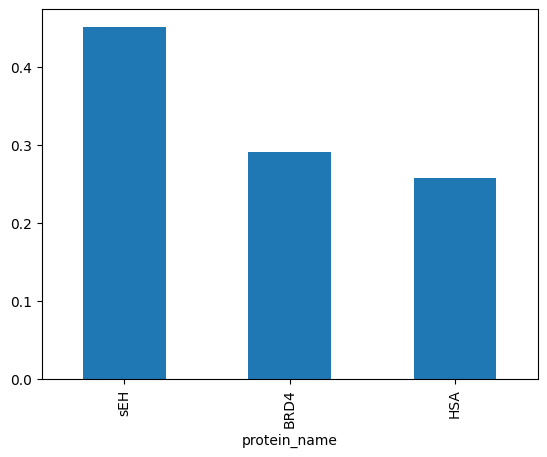

In [42]:
df[df['binds'] == 1]['protein_name'].value_counts(normalize=True).plot(kind='bar')

In [43]:
import torch
from transformers import AutoModelForMaskedLM, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
model = AutoModelForMaskedLM.from_pretrained("DeepChem/ChemBERTa-77M-MTR")

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit import DataStructs
from rdkit.Chem import Descriptors
from rdkit.Chem.Descriptors import CalcMolDescriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem
from mordred import Calculator, descriptors

In [45]:
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit import RDLogger

# Suppress RDKit warnings and info messages
RDLogger.DisableLog('rdApp.*')

# Create canonical smiles to check for duplicates
def canonical_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return Chem.MolToSmiles(mol)
    else:
        return False

# Example usage with a DataFrame column
def process_dataframe(df):
    canonical_smiles_list = []
    for smiles in tqdm(df['molecule_smiles'], desc="Processing DataFrame"):
        canonical_smiles_list.append(canonical_smiles(smiles))
    df['canonical_smiles'] = canonical_smiles_list
    return df

# Process the DataFrame
df = process_dataframe(df)
df.head()

Processing DataFrame:   0%|          | 0/60000 [00:00<?, ?it/s]

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds,canonical_smiles
0,157421086,O=C(Nc1cc(Br)c(Cl)cc1C(=O)O)OCC1c2ccccc2-c2ccc...,Cl.NC1CCC(=O)CC1,Cc1cccc(N)c1Cl,Cc1cccc(Nc2nc(Nc3cc(Br)c(Cl)cc3C(=O)N[Dy])nc(N...,HSA,0,Cc1cccc(Nc2nc(Nc3cc(Br)c(Cl)cc3C(=O)N[Dy])nc(N...
1,42705092,CSc1ncc(NC(=O)OCC2c3ccccc3-c3ccccc32)c(C(=O)O)n1,COC1(OC)CC(CN)C1,CC(=O)c1ccc(N)c(F)c1,COC1(OC)CC(CNc2nc(Nc3ccc(C(C)=O)cc3F)nc(Nc3cnc...,sEH,0,COC1(OC)CC(CNc2nc(Nc3ccc(C(C)=O)cc3F)nc(Nc3cnc...
2,68338321,N#Cc1ccc(NC(=O)OCC2c3ccccc3-c3ccccc32)c(C(=O)O)c1,NC[C@@H]1CCC(=O)N1,Cc1cc2cc(CN)ccc2[nH]1,Cc1cc2cc(CNc3nc(NC[C@@H]4CCC(=O)N4)nc(Nc4ccc(C...,HSA,0,Cc1cc2cc(CNc3nc(NC[C@@H]4CCC(=O)N4)nc(Nc4ccc(C...
3,204282053,O=C(Nc1ccc([N+](=O)[O-])c(C(=O)O)c1)OCC1c2cccc...,Cl.NCC(F)(F)C1CC1,Nc1cc(F)c(F)cc1Br,O=C(N[Dy])c1cc(Nc2nc(NCC(F)(F)C3CC3)nc(Nc3cc(F...,sEH,0,O=C(N[Dy])c1cc(Nc2nc(NCC(F)(F)C3CC3)nc(Nc3cc(F...
4,111143616,O=C(N[C@H](C(=O)O)C1CC1)OCC1c2ccccc2-c2ccccc21,CC(=O)SCCN.Cl,Nc1nc2ccccc2[nH]1,CC(=O)SCCNc1nc(Nc2nc3ccccc3[nH]2)nc(N[C@H](C(=...,BRD4,0,CC(=O)SCCNc1nc(Nc2nc3ccccc3[nH]2)nc(N[C@H](C(=...


In [47]:
df = df.drop_duplicates(subset=['canonical_smiles'])


In [48]:
df['canonical_smiles_len'] = df['canonical_smiles'].apply(len)
df['canonical_smiles_len'].info()

<class 'pandas.core.series.Series'>
Index: 59960 entries, 0 to 59999
Series name: canonical_smiles_len
Non-Null Count  Dtype
--------------  -----
59960 non-null  int64
dtypes: int64(1)
memory usage: 936.9 KB


<ipython-input-48-41241d901739>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['canonical_smiles_len'] = df['canonical_smiles'].apply(len)


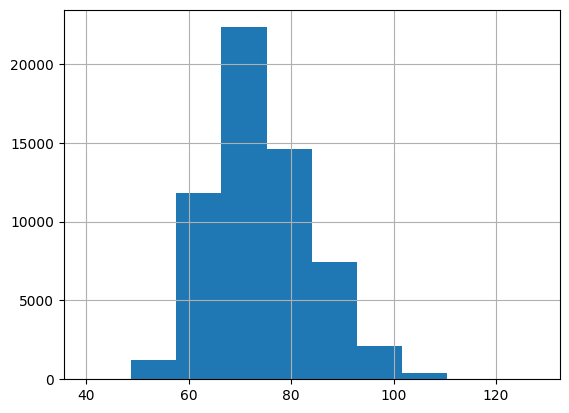

In [49]:
df['canonical_smiles_len'].hist()
max_len = 100

In [50]:
#hyperparameters
epochs = 10
batch_size = 128
learning_rate = 1e-3

In [51]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
model = AutoModelForSequenceClassification.from_pretrained("DeepChem/ChemBERTa-77M-MTR", num_labels=2).to(device)

# Define a custom dataset class
class SMILESDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.dataframe = dataframe
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        smiles = self.dataframe.iloc[idx]['canonical_smiles']
        label = self.dataframe.iloc[idx]['binds']
        return smiles, label

    def collate_fn(self, batch):
        # Tokenize and convert to tensors
        tokenized_batch = [self.tokenizer.encode(smiles, add_special_tokens=True) for smiles, _ in batch]
        padded_batch = pad_sequence([torch.tensor(tokens) for tokens in tokenized_batch],
                                    batch_first=True, padding_value=self.tokenizer.pad_token_id)

        labels = torch.tensor([label for _, label in batch], dtype=torch.long)

        return padded_batch, labels

# Split the data into training and validation sets
train_df, test_df = train_test_split(df, test_size=0.2)

# Create datasets and data loaders
train_dataset = SMILESDataset(train_df, tokenizer)
val_dataset = SMILESDataset(test_df, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=val_dataset.collate_fn)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

# Training and validation loop
epochs = 10
train_losses = []
val_losses = []
train_acc = []
val_acc = []

for epoch in tqdm(range(epochs)):

    train_loss = 0
    train_correct = 0
    train_count = 0

    model.train()
    for inputs, labels in train_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)
        attention_mask = (inputs != tokenizer.pad_token_id).type(torch.long).to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=inputs, attention_mask=attention_mask)
        logits = outputs.logits  # Shape: [batch_size, num_labels]

        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        train_correct += (preds == labels).sum().item()
        train_count += labels.size(0)

    avg_train_loss = train_loss / train_count
    train_losses.append(avg_train_loss)
    train_accuracy = train_correct / train_count
    train_acc.append(train_accuracy)

    # Evaluation loop
    val_loss = 0
    val_correct = 0
    val_count = 0

    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            attention_mask = (inputs != tokenizer.pad_token_id).type(torch.long).to(device)

            outputs = model(input_ids=inputs, attention_mask=attention_mask)
            logits = outputs.logits  # Shape: [batch_size, num_labels]

            loss = loss_fn(logits, labels)
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == labels).sum().item()
            val_count += labels.size(0)

    avg_val_loss = val_loss / val_count
    val_losses.append(avg_val_loss)
    val_accuracy = val_correct / val_count
    val_acc.append(val_accuracy)

    print(f'Epoch: {epoch}')
    print(f'Train Loss: {avg_train_loss}')
    print(f'Train Accuracy: {train_accuracy}')
    print(f'Validation Loss: {avg_val_loss}')
    print(f'Validation Accuracy: {val_accuracy}')


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 0.0032575953331806405
Train Accuracy: 0.8144596397598399
Validation Loss: 0.0027341008313084697
Validation Accuracy: 0.8584056037358239
Epoch: 1
Train Loss: 0.0027480720212463144
Train Accuracy: 0.8535273515677118
Validation Loss: 0.0025926202006285154
Validation Accuracy: 0.8709139426284189
Epoch: 2
Train Loss: 0.002585666969274385
Train Accuracy: 0.8644096064042696
Validation Loss: 0.002487006062285116
Validation Accuracy: 0.8729152768512342
Epoch: 3
Train Loss: 0.002477509681610086
Train Accuracy: 0.8708305537024683
Validation Loss: 0.0024783566725838572
Validation Accuracy: 0.8762508338892595
Epoch: 4
Train Loss: 0.0024176253095328846
Train Accuracy: 0.875792194796531
Validation Loss: 0.0026016523260088903
Validation Accuracy: 0.8652434956637759
Epoch: 5
Train Loss: 0.002343446041784778
Train Accuracy: 0.8778977651767845
Validation Loss: 0.002491955627364823
Validation Accuracy: 0.8783355570380253
Epoch: 6
Train Loss: 0.0022949499681994587
Train Accuracy: 0.882

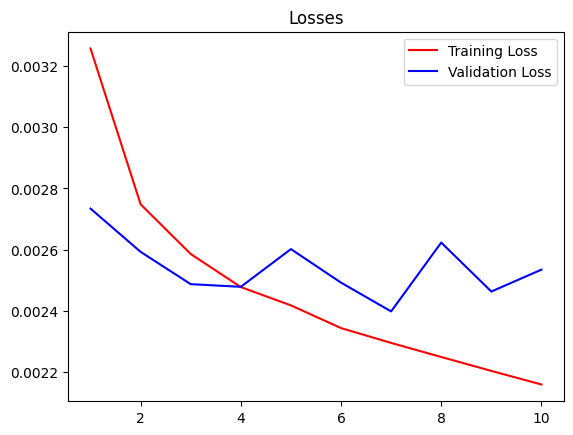

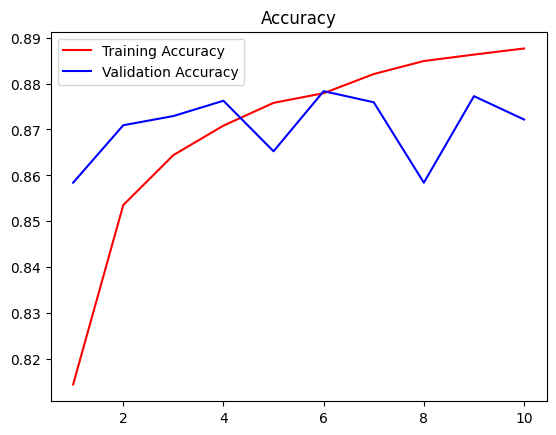

In [61]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(1, epochs+1), train_losses, c='r',label='Training Loss')
plt.plot(np.arange(1, epochs+1), val_losses, c='b', label='Validation Loss')
plt.legend()
plt.title("Losses")
plt.show()

plt.plot(np.arange(1, epochs+1), train_acc, c='r',label='Training Accuracy')
plt.plot(np.arange(1, epochs+1), val_acc, c='b', label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")
plt.show()

In [ ]:
len(dataset)

59970

In [ ]:
df['binds'].value_counts()

binds
0    30000
1    30000
Name: count, dtype: int64

In [ ]:
def RDkit_descriptors(smiles):
  mols = [Chem.MolFromSmiles(i) for i in tqdm(smiles, desc="Processing SMILES")]
  calc = MoleculeDescriptors.MolecularDescriptorCalculator(x[0] for x in Descriptors._descList)
  desc_names = calc.GetDescriptorNames()

  Mol_descriptors = []
  for mol in tqdm(mols, desc='Calculating Descriptors'):
    mol = Chem.AddHs(mol)
    descriptors = calc.CalcDescriptors(mol)
    Mol_descriptors.append(descriptors)
  return Mol_descriptors, desc_names

descriptors, desc_names = RDkit_descriptors(dataset['SMILES'])

Processing SMILES:   0%|          | 0/59970 [00:00<?, ?it/s]

Calculating Descriptors:   0%|          | 0/59970 [00:00<?, ?it/s]

In [ ]:
descriptors

<module 'mordred.descriptors' from '/usr/local/lib/python3.10/dist-packages/mordred/descriptors/__init__.py'>

In [ ]:
df_descriptors = pd.DataFrame(descriptors, columns=desc_names)
df_descriptors

ValueError: DataFrame constructor not properly called!

In [ ]:
df_descriptors

<bound method DataFrame.reset_index of        MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  \
0              13.725293       13.725293           0.175546       -4.006164   
1              14.066757       14.066757           0.073453       -4.062658   
2              12.726066       12.726066           0.038279       -4.500541   
3              13.353804       13.353804           0.012709       -4.077827   
4              12.647315       12.647315           0.049664       -5.695602   
...                  ...             ...                ...             ...   
59965          13.283600       13.283600           0.459466       -4.924245   
59966          13.774960       13.774960           0.414759       -4.841710   
59967          13.677773       13.677773           0.016500       -6.120566   
59968          13.173068       13.173068           0.422096       -4.920931   
59969          13.965544       13.965544           0.118900       -4.835038   

            qed        SPS    MolWt  HeavyAtomMolWt  ExactMolWt  \
0      0.273057  31.000000  646.063         626.911  647.042562   
1      0.136261  22.250000  661.024         639.856  662.076385   
2      0.152165  33.105263  667.079         636.839  668.187569   
3      0.176018  27.024390  724.108         698.908  725.107270   
4      0.121606  19.076923  727.981         707.821  728.029036   
...         ...        ...      ...             ...         ...   
59965  0.314837  82.540541  659.180         616.844  660.269173   
59966  0.157707  24.121951  713.056         684.832  714.145429   
59967  0.111851  23.790698  755.122         728.914  756.113084   
59968  0.240004  54.833333  641.121         604.833  642.222223   
59969  0.244149  36.228571  630.018         602.802  631.167168   

       NumValenceElectrons  ...  fr_sulfide  fr_sulfonamd  fr_sulfone  \
0                      179  ...           0             0           0   
1                      191  ...           0             0           0   
2                      203  ...           0             0           0   
3                      215  ...           0             0           0   
4                      201  ...           0             0           0   
...                    ...  ...         ...           ...         ...   
59965                  207  ...           0             0           0   
59966                  219  ...           0             0           0   
59967                  227  ...           0             1           0   
59968                  197  ...           0             0           0   
59969                  189  ...           0             0           0   

       fr_term_acetylene  fr_tetrazole  fr_thiazole  fr_thiocyan  \
0                      0             0            1            0   
1                      1             0            1            0   
2                      0             0            0            0   
3                      0             0            1            0   
4                      0             0            0            0   
...                  ...           ...          ...          ...   
59965                  0             0            0            0   
59966                  0             0            0            0   
59967                  0             0            0            0   
59968                  0             0            0            0   
59969                  0             1            0            0   

       fr_thiophene  fr_unbrch_alkane  fr_urea  
0                 0                 0        0  
1                 0                 0        0  
2                 0                 0        0  
3                 0                 0        0  
4                 0                 0        0  
...             ...               ...      ...  
59965             0                 0        0  
59966             0                 0        0  
59967             0                 0        0  
59968             0    

In [ ]:
pd.concat([dataset, df_descriptors], axis=1, ignore_index=True)

TypeError: cannot concatenate object of type '<class 'method'>'; only Series and DataFrame objs are valid

In [ ]:
import numpy as np

def morgan_fpts(data):
  Morgan_fpts = []
  for i in tqdm(data, desc='Creating Fingerprints'):
    mol = Chem.MolFromSmiles(i)
    fpts = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048)
    mfpts = np.array(fpts)
    Morgan_fpts.append(mfpts)
  return np.array(Morgan_fpts)

Morgan_fpts = morgan_fpts(dataset['SMILES'])
Morgan_fpts.shape

Creating Fingerprints:   0%|          | 0/59970 [00:00<?, ?it/s]

(59970, 2048)

In [ ]:
df_morgan_fpts = pd.DataFrame(Morgan_fpts, columns=['mp_{}'.format(i) for i in range(Morgan_fpts.shape[1])])

Cc1cn(-c2cc(Nc3nc(NCc4cc(-c5ccccc5)[nH]n4)nc(Nc4cccc(F)c4C(=O)N[Dy])n3)cc(C(F)(F)F)c2)cn1
48


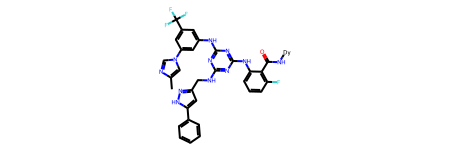

In [ ]:
print(df['molecule_smiles'].iloc[0])
print(Chem.MolFromSmiles(df['molecule_smiles'].iloc[0], sanitize=True).GetNumAtoms())
Chem.MolFromSmiles(df['molecule_smiles'].iloc[0], sanitize=True)

[Chemical Table Files](https://en.wikipedia.org/wiki/Chemical_table_file)

In [ ]:
# Molecular Representations
print(Chem.MolToMolBlock(Chem.MolFromSmiles(df['molecule_smiles'].iloc[0], sanitize=True)))


     RDKit          2D

 38 43  0  0  0  0  0  0  0  0999 V2000
    3.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.5000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7500   -1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.7500   -1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.5000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.7500    1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.2135    2.7256    0.0000 S   0  0  0  0  0  0  0  0  0  0  0  0
   -0.0000    3.6073    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.0000    5.1073    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
    1.2990    5.8573    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.5981    5.1073    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
    3.8971    5.8573    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    5.1962    5.1073    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
    5.1962    3.6073    0

O=C(O)[C@H]1CCCCN1C(=O)OCC1c2ccccc2-c2ccccc21


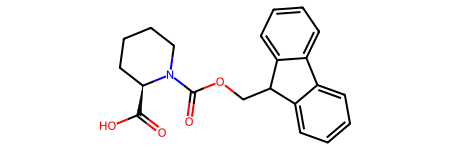

In [ ]:
print(df['buildingblock1_smiles'].iloc[0])
Chem.MolFromSmiles(df['buildingblock1_smiles'].iloc[0], sanitize=True)

In [ ]:
from rdkit.Chem import AllChem
mol_H = Chem.AddHs(Chem.MolFromSmiles(df['buildingblock1_smiles'].iloc[0], sanitize=True))
AllChem.EmbedMolecule(mol_H)

0

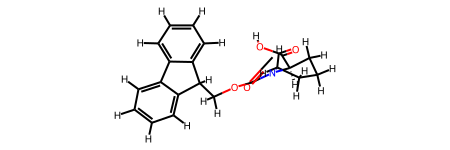

In [ ]:
mol_H

In [ ]:
print(Chem.MolToMolBlock(mol_H))


     RDKit          3D

 47 50  0  0  0  0  0  0  0  0999 V2000
    4.0693    1.3670   -2.8057 O   0  0  0  0  0  0  0  0  0  0  0  0
    3.2170    1.0797   -1.9092 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.9392    1.5364   -2.0691 O   0  0  0  0  0  0  0  0  0  0  0  0
    3.7164    0.2691   -0.7750 C   0  0  1  0  0  0  0  0  0  0  0  0
    4.8894    0.8658   -0.0891 C   0  0  0  0  0  0  0  0  0  0  0  0
    5.3575   -0.1360    0.9748 C   0  0  0  0  0  0  0  0  0  0  0  0
    4.2826   -0.3067    2.0283 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.9726    0.2999    1.5733 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.6839   -0.0212    0.1901 N   0  0  0  0  0  0  0  0  0  0  0  0
    1.4323   -0.6008   -0.1977 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.1709   -0.8849   -1.3924 O   0  0  0  0  0  0  0  0  0  0  0  0
    0.4309   -0.8860    0.7121 O   0  0  0  0  0  0  0  0  0  0  0  0
   -0.8012   -1.4460    0.3962 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.6420   -0.6381   -0

Cl.Cl.NCc1nc2cnccc2s1


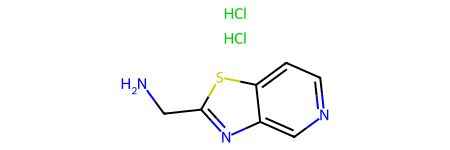

In [ ]:
print(df['buildingblock2_smiles'].iloc[0])
Chem.MolFromSmiles(df['buildingblock2_smiles'].iloc[0], sanitize=True)

Cc1cccc2sc(N)nc12


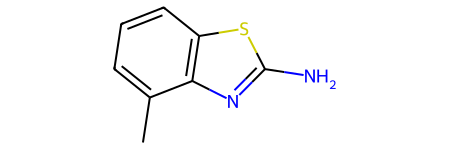

In [ ]:
print(df['buildingblock3_smiles'].iloc[0])
Chem.MolFromSmiles(df['buildingblock3_smiles'].iloc[0], sanitize=True)

In [ ]:
data_small = df.head(100).copy()
PandasTools.AddMoleculeColumnToFrame(data_small, smilesCol='molecule_smiles', molCol='molecular_representation')

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds,molecular_representation
0,289227411,O=C(O)[C@H]1CCCCN1C(=O)OCC1c2ccccc2-c2ccccc21,Cl.Cl.NCc1nc2cnccc2s1,Cc1cccc2sc(N)nc12,Cc1cccc2sc(Nc3nc(NCc4nc5cnccc5s4)nc(N4CCCC[C@@...,BRD4,0,
1,267426450,O=C(O)C[C@H](Cc1ccc(Cl)c(Cl)c1)NC(=O)OCC1c2ccc...,Cl.Cl.NCc1cncc(F)c1,Cc1cc(N)n(-c2ccccc2)n1,Cc1cc(Nc2nc(NCc3cncc(F)c3)nc(N[C@H](CC(=O)N[Dy...,BRD4,0,
2,161212930,O=C(Nc1cc(Br)ccc1C(=O)O)OCC1c2ccccc2-c2ccccc21,Nc1ncc([N+](=O)[O-])s1,C=CCNC(=O)CN.Cl,C=CCNC(=O)CNc1nc(Nc2ncc([N+](=O)[O-])s2)nc(Nc2...,HSA,0,
3,37496971,COc1ccc([C@H](NC(=O)OCC2c3ccccc3-c3ccccc32)C(=...,Cl.Cl.Cn1ccnc1Cn1c(CCCN)nc2c1CCCC2,Cc1csc(N)n1,COc1ccc([C@H](Nc2nc(NCCCc3nc4c(n3Cc3nccn3C)CCC...,HSA,0,
4,110566368,O=C(N[C@@H]1CC[C@H](C(=O)O)C1)OCC1c2ccccc2-c2c...,Cl.N#CC1(NC(=O)CN)CC1,Cc1cc(N)ncn1,Cc1cc(Nc2nc(NCC(=O)NC3(C#N)CC3)nc(N[C@@H]3CC[C...,BRD4,0,
...,...,...,...,...,...,...,...,...
95,64256700,N#Cc1ccc(C[C@@H](CC(=O)O)NC(=O)OCC2c3ccccc3-c3...,Nc1nccc(Cl)n1,COC(=O)Cc1nc(N)sc1C,COC(=O)Cc1nc(Nc2nc(Nc3nccc(Cl)n3)nc(N[C@H](CC(...,BRD4,0,
96,239595667,O=C(O)CC1(NC(=O)OCC2c3ccccc3-c3ccccc32)CCCCC1,Nc1cccnc1[N+](=O)[O-],N#Cc1ncc(N)cc1C(F)(F)F,N#Cc1ncc(Nc2nc(Nc3cccnc3[N+](=O)[O-])nc(NC3(CC...,HSA,0,
97,199256449,O=C(Nc1ccc(Cl)cc1C(=O)O)OCC1c2ccccc2-c2ccccc21,Nc1ccc2cnccc2c1,Cl.Nc1cccc2c(=O)cc(-c3nn[nH]n3)oc12,O=C(N[Dy])c1cc(Cl)ccc1Nc1nc(Nc2ccc3cnccc3c2)nc...,HSA,0,
98,97974318,O=C(N[C@@H](Cc1ccc(F)c(F)c1)C(=O)O)OCC1c2ccccc...,Nc1cnc(Br)cn1,CCOC(=O)c1cnc(SC)nc1N,CCOC(=O)c1cnc(SC)nc1Nc1nc(Nc2cnc(Br)cn2)nc(N[C...,BRD4,0,

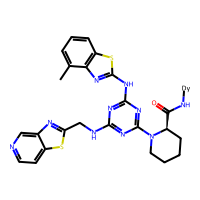
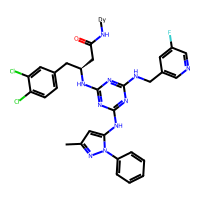
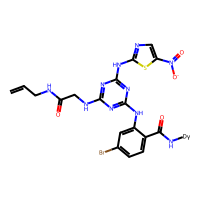
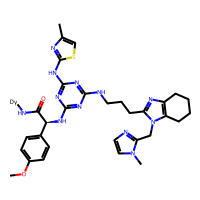
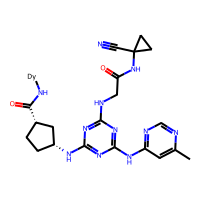
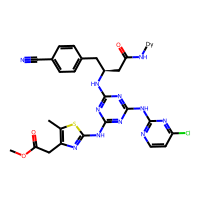
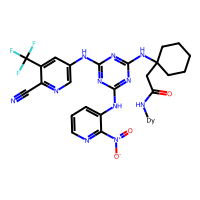
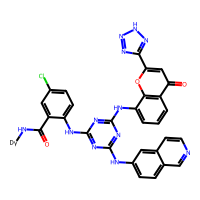
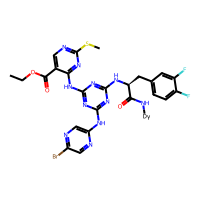
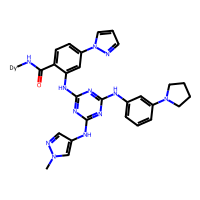

In [ ]:
data_small